In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import glob
from scipy.stats import pearsonr

RECOMPUTE_RESULTS = False
DATA = "DC"

In [ ]:
if RECOMPUTE_RESULTS:
    gpt2_bigram_surpisals = json.load(open(f"../results/ngram/{DATA}/gpt2_2gram.arpa/surprisal_tokenized.json"))
    gpt2_flatten_bigram = [s for sss in gpt2_bigram_surpisals.values() for ss in sss for s in ss]

    opt_bigram_surpisals = json.load(open(f"../results/ngram/{DATA}/opt_2gram.arpa/surprisal.json"))
    opt_flatten_bigram = [s for sss in opt_bigram_surpisals.values() for ss in sss for s in ss]

    pythia_bigram_surpisals = json.load(open(f"../results/ngram/{DATA}/pythia_2gram.arpa/surprisal.json"))
    pythia_flatten_bigram = [s for sss in pythia_bigram_surpisals.values() for ss in sss for s in ss]

    best_surprisals = json.load(open("../results/logit-lens/DC/opt-66b/surprisal.json"))
    flatten_best = [s for sss in best_surprisals["64"].values() for ss in sss for s in ss]

    all_data = []
    files = glob.glob("../results/tuned-lens/DC/**/surprisal.json", recursive=True)
    for file in files:
        model = file.split("/")[-2]
        surprisals = json.load(open(file))
        for layer_i, data in surprisals.items():
            flatten_gpt = [s for sss in data.values() for ss in sss for s in ss]
            if "gpt2" in model:
                bigram = gpt2_flatten_bigram
            elif "opt" in model:
                bigram = opt_flatten_bigram
            elif "pythia" in model:
                bigram = pythia_flatten_bigram
            all_data.append({"model": model, "layer": int(layer_i), "bigram_correl": pearsonr(flatten_gpt, bigram)[0], "accurate_correl": pearsonr(flatten_gpt, flatten_best)[0]})

    df = pd.DataFrame.from_records(all_data)
    df["relative_layer"] = df.apply(lambda x: x["layer"]/df[df["model"]==x["model"]]["layer"].max(), axis=1)
    df["normalized_bigram_correl"] = df.apply(lambda x: (x["bigram_correl"]-df[df["model"]==x["model"]]["bigram_correl"].min())/(df[df["model"]==x["model"]]["bigram_correl"].max() - df[df["model"]==x["model"]]["bigram_correl"].min()),axis=1) 
    df["normalized_accurate_correl"] = df.apply(lambda x: (x["accurate_correl"]-df[df["model"]==x["model"]]["accurate_correl"].min())/(df[df["model"]==x["model"]]["accurate_correl"].max() - df[df["model"]==x["model"]]["accurate_correl"].min()),axis=1)     
    df.to_csv(f"../results/{DATA}_contextualization.csv")
else:
    df = pd.read_csv(f"../results/{DATA}_contextualization.csv")

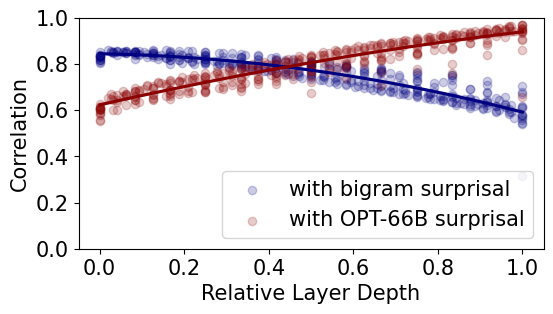

In [5]:
plt.figure(figsize=(6, 3))
sns.regplot(x=df["relative_layer"], y=df["bigram_correl"], marker='o', color="navy", label="with bigram surprisal", scatter_kws={"alpha": 0.2}, order=2)
sns.regplot(x=df["relative_layer"], y=df["accurate_correl"], marker='o', color="darkred", label="with OPT-66B surprisal", scatter_kws={"alpha": 0.2}, order=2)
plt.ylim([0,1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Relative Layer Depth", fontsize=15)
plt.legend(fontsize=15, loc="lower right")
plt.savefig("figures/contextualization.pdf", bbox_inches="tight")

In [14]:
print(pearsonr(df["relative_layer"], df["normalized_bigram_correl"]))
print(pearsonr(df["relative_layer"], df["normalized_accurate_correl"]))

PearsonRResult(statistic=-0.9239266661152086, pvalue=1.8586758466629736e-151)
PearsonRResult(statistic=0.9514277287876142, pvalue=3.0395641593905904e-185)
